# Quantitative Finance Model using Donadio and Ghosh Learn Algorithmic Trading Chapter 5 Basic Trend Following Example
### David Lowe
### September 7, 2022

NOTE: This script is for learning purposes only and does not constitute a recommendation for buying or selling any stock mentioned in this script.

SUMMARY: This project aims to construct and test an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: This script aims to replicate the Basic Trend Following example found in chapter five of the book Learn Algorithmic Trading by Sebastien Donadio and Sourav Ghosh. The script seeks to validate the Python environment and package requirements for running these code examples successfully. The eventual goal is to integrate various example code segments from the book into an end-to-end algorithmic trading system.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Sharadar US Equities and Fund Prices from Quandl/Nasdaq Data Link

Source and Further Discussion of the Code Examples: https://github.com/PacktPublishing/Learn-Algorithmic-Trading

# Task 1 - Prepare Environment

## 1.a) Load the required packages and modules

In [1]:
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
# from pandas_datareader import data

## 1.b) Set up the controlling parameters and functions

In [2]:
# Specify the key modeling parameters below
DATA_STORE = '../sharadar.h5'
SYMBOL = 'GOOGL'
NUM_PERIODS_FAST = 10 # Static time period parameter for the fast EMA
NUM_PERIODS_SLOW = 40 # Static time period parameter for slow EMA

# Constants that define strategy behavior/thresholds
APO_VALUE_FOR_BUY_ENTRY = -1 # APO trading signal value below which to enter buy-orders/long-position
APO_VALUE_FOR_SELL_ENTRY = 1 # APO trading signal value above which to enter sell-orders/short-position
MIN_PRICE_MOVE_FROM_LAST_TRADE = 5 # Minimum price change since last trade before considering trading again, this is to prevent over-trading at/around same prices
NUM_SHARES_PER_TRADE = 100 # Number of shares to buy/sell on every trade
MIN_PROFIT_TO_CLOSE = 10*NUM_SHARES_PER_TRADE # Minimum Open/Unrealized profit at which to close positions and lock profits

MODEL_START_DATE = date(2014, 1, 1)
print("Starting date for the model:", MODEL_START_DATE)

# MODEL_END_DATE = datetime.now().date()
MODEL_END_DATE = date(2018, 12, 31)
print("Ending date for the model:", MODEL_END_DATE)

# Set Pandas dsiplay parameters
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Starting date for the model: 2014-01-01
Ending date for the model: 2018-12-31


# Task 2 - Acquire and Pre-Process Data

## Instead of using pandas-datareader like in the book example, this script will use another commercial data source.

In [3]:
with pd.HDFStore(DATA_STORE) as store:
    data = (store['quandl/sharadar/sep'].loc[[SYMBOL], ['open', 'high', 'low', 'close', 'volume']])
data.reset_index(level=0, inplace=True)
data.sort_index(inplace=True)
data = data[MODEL_START_DATE:MODEL_END_DATE]
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2014-01-02 to 2018-12-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ticker  1258 non-null   object 
 1   open    1258 non-null   float64
 2   high    1258 non-null   float64
 3   low     1258 non-null   float64
 4   close   1258 non-null   float64
 5   volume  1258 non-null   float64
dtypes: float64(5), object(1)
memory usage: 68.8+ KB


In [4]:
print(data.head())

           ticker    open    high     low   close       volume
date                                                          
2014-01-02  GOOGL  27.914  27.972  27.734  27.856   72782000.0
2014-01-03  GOOGL  27.903  27.951  27.651  27.653   66600000.0
2014-01-06  GOOGL  27.853  28.000  27.689  27.961   70700000.0
2014-01-07  GOOGL  28.153  28.521  28.057  28.500  102000000.0
2014-01-08  GOOGL  28.679  28.712  28.361  28.559   89610000.0


# Task 3 - Set up the Helper Functions for Modeling

In [5]:
# Not applicable for this iteration of modeling

# Task 4 - Build Model

In [6]:
# Variables/constants for EMA Calculation:
K_FAST = 2 / (NUM_PERIODS_FAST + 1) # Static smoothing factor parameter for fast EMA
ema_fast = 0
ema_fast_values = [] # we will hold fast EMA values for visualization purposes

K_SLOW = 2 / (NUM_PERIODS_SLOW + 1) # Static smoothing factor parameter for slow EMA
ema_slow = 0
ema_slow_values = [] # we will hold slow EMA values for visualization purposes

apo_values = [] # track computed absolute price oscillator value signals

# Variables for Trading Strategy trade, position & pnl management:
orders = [] # Container for tracking buy/sell order, +1 for buy order, -1 for sell order, 0 for no-action
positions = [] # Container for tracking positions, +ve for long positions, -ve for short positions, 0 for flat/no position
pnls = [] # Container for tracking total_pnls, this is the sum of closed_pnl i.e. pnls already locked in and open_pnl i.e. pnls for open-position marked to market price

last_buy_price = 0 # Price at which last buy trade was made, used to prevent over-trading at/around the same price
last_sell_price = 0 # Price at which last sell trade was made, used to prevent over-trading at/around the same price
position = 0 # Current position of the trading strategy
buy_sum_price_qty = 0 # Summation of products of buy_trade_price and buy_trade_qty for every buy Trade made since last time being flat
buy_sum_qty = 0 # Summation of buy_trade_qty for every buy Trade made since last time being flat
sell_sum_price_qty = 0 # Summation of products of sell_trade_price and sell_trade_qty for every sell Trade made since last time being flat
sell_sum_qty = 0 # Summation of sell_trade_qty for every sell Trade made since last time being flat
open_pnl = 0 # Open/Unrealized PnL marked to market
closed_pnl = 0 # Closed/Realized PnL so far

close=data['close']
for close_price in close:
    # This section updates fast and slow EMA and computes APO trading signal
    if ema_fast == 0 : # first observation
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = (close_price - ema_fast) * K_FAST + ema_fast
        ema_slow = (close_price - ema_slow) * K_SLOW + ema_slow

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)

    apo = ema_fast - ema_slow
    apo_values.append(apo)

    # This section checks trading signal against trading parameters/thresholds and positions, to trade.

    # We will perform a sell trade at close_price if the following conditions are met:
    # 1. The APO trading signal value is below Sell-Entry threshold and the difference between last trade-price and current-price is different enough.
    # 2. We are long( +ve position ) and either APO trading signal value is at or below 0 or current position is profitable enough to lock profit.
    if ((apo > APO_VALUE_FOR_SELL_ENTRY and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE) # APO above sell entry threshold, we should sell
        or (position > 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE))): # long from +ve APO and APO has gone negative or position is profitable, sell to close position
        orders.append(-1) # mark the sell trade
        last_sell_price = close_price
        position -= NUM_SHARES_PER_TRADE # reduce position by the size of this trade
        sell_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # update vwap sell-price
        sell_sum_qty += NUM_SHARES_PER_TRADE
        print( "Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )

    # We will perform a buy trade at close_price if the following conditions are met:
    # 1. The APO trading signal value is above Buy-Entry threshold and the difference between last trade-price and current-price is different enough.
    # 2. We are short( -ve position ) and either APO trading signal value is at or above 0 or current position is profitable enough to lock profit.
    elif ((apo > APO_VALUE_FOR_BUY_ENTRY and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE) # APO above buy entry threshold, we should buy
        or (position < 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE))): # short from -ve APO and APO has gone positive or position is profitable, buy to close position
        orders.append(+1) # mark the buy trade
        last_buy_price = close_price
        position += NUM_SHARES_PER_TRADE # increase position by the size of this trade
        buy_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # update the vwap buy-price
        buy_sum_qty += NUM_SHARES_PER_TRADE
        print( "Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )
    else:
        # No trade since none of the conditions were met to buy or sell
        orders.append(0)

    positions.append(position)

    # This section updates Open/Unrealized & Closed/Realized positions
    open_pnl = 0
    if position > 0:
        if sell_sum_qty > 0: # long position and some sell trades have been made against it, close that amount based on how much was sold against this long position
            open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
    elif position < 0:
        if buy_sum_qty > 0: # short position and some buy trades have been made against it, close that amount based on how much was bought against this short position
            open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty/sell_sum_qty - close_price)
    else:
        # flat, so update closed_pnl and reset tracking variables for positions & pnls
        closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
        buy_sum_price_qty = 0
        buy_sum_qty = 0
        sell_sum_price_qty = 0
        sell_sum_qty = 0
        last_buy_price = 0
        last_sell_price = 0

    print( "OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl) )
    pnls.append(closed_pnl + open_pnl)

Buy  100  @  27.856 Position:  100
OpenPnL:  -3.552713678800501e-13  ClosedPnL:  0  TotalPnL:  -3.552713678800501e-13
Sell  100  @  27.653 Position:  0
OpenPnL:  0  ClosedPnL:  -20.300000000000637  TotalPnL:  -20.300000000000637
Buy  100  @  27.961 Position:  100
OpenPnL:  0.0  ClosedPnL:  -20.300000000000637  TotalPnL:  -20.300000000000637
OpenPnL:  53.90000000000015  ClosedPnL:  -20.300000000000637  TotalPnL:  33.59999999999951
OpenPnL:  59.80000000000025  ClosedPnL:  -20.300000000000637  TotalPnL:  39.499999999999616
OpenPnL:  32.30000000000004  ClosedPnL:  -20.300000000000637  TotalPnL:  11.999999999999403
OpenPnL:  32.20000000000027  ClosedPnL:  -20.300000000000637  TotalPnL:  11.899999999999636
OpenPnL:  14.200000000000301  ClosedPnL:  -20.300000000000637  TotalPnL:  -6.100000000000335
OpenPnL:  80.30000000000008  ClosedPnL:  -20.300000000000637  TotalPnL:  59.999999999999446
OpenPnL:  78.30000000000013  ClosedPnL:  -20.300000000000637  TotalPnL:  57.99999999999949
OpenPnL:  97.3

In [7]:
# This section prepares the dataframe from the trading strategy results and visualizes the results
data = data.assign(ClosePrice=pd.Series(close, index=data.index))
data = data.assign(Fast10DayEMA=pd.Series(ema_fast_values, index=data.index))
data = data.assign(Slow40DayEMA=pd.Series(ema_slow_values, index=data.index))
data = data.assign(APO=pd.Series(apo_values, index=data.index))
data = data.assign(Trades=pd.Series(orders, index=data.index))
data = data.assign(Position=pd.Series(positions, index=data.index))
data = data.assign(Pnl=pd.Series(pnls, index=data.index))

print(data.head())

           ticker    open    high     low   close       volume  ClosePrice  Fast10DayEMA  Slow40DayEMA       APO  Trades  Position           Pnl
date                                                                                                                                            
2014-01-02  GOOGL  27.914  27.972  27.734  27.856   72782000.0      27.856     27.856000     27.856000  0.000000       1       100 -3.552714e-13
2014-01-03  GOOGL  27.903  27.951  27.651  27.653   66600000.0      27.653     27.819091     27.846098 -0.027007      -1         0 -2.030000e+01
2014-01-06  GOOGL  27.853  28.000  27.689  27.961   70700000.0      27.961     27.844893     27.851703 -0.006810       1       100 -2.030000e+01
2014-01-07  GOOGL  28.153  28.521  28.057  28.500  102000000.0      28.500     27.964003     27.883327  0.080676       0       100  3.360000e+01
2014-01-08  GOOGL  28.679  28.712  28.361  28.559   89610000.0      28.559     28.072184     27.916286  0.155898       0       100

# Task 5 - Evaluate Model Performance

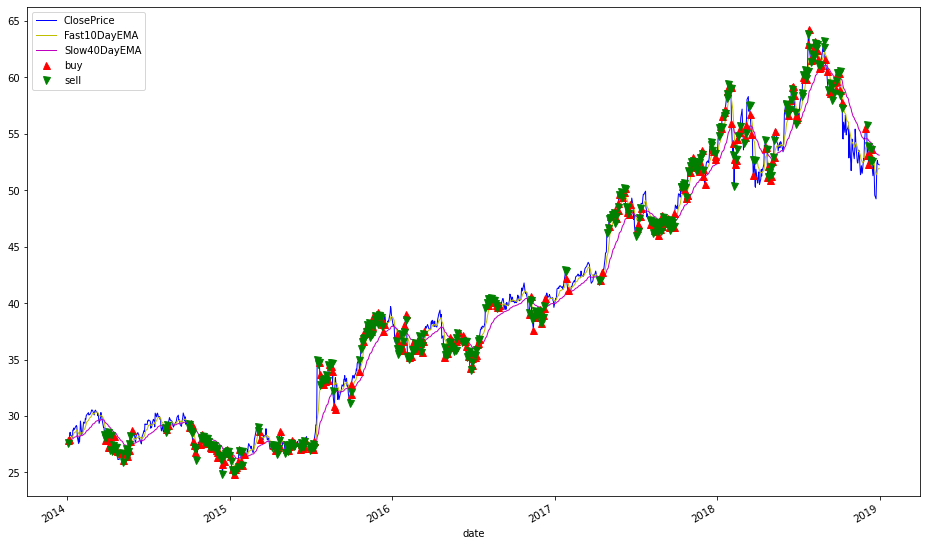

In [8]:
plt.figure(figsize=(16,10))
data['ClosePrice'].plot(color='blue', lw=1., legend=True)
data['Fast10DayEMA'].plot(color='y', lw=1., legend=True)
data['Slow40DayEMA'].plot(color='m', lw=1., legend=True)
plt.plot(data.loc[ data.Trades == 1 ].index, data.ClosePrice[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.ClosePrice[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.show()

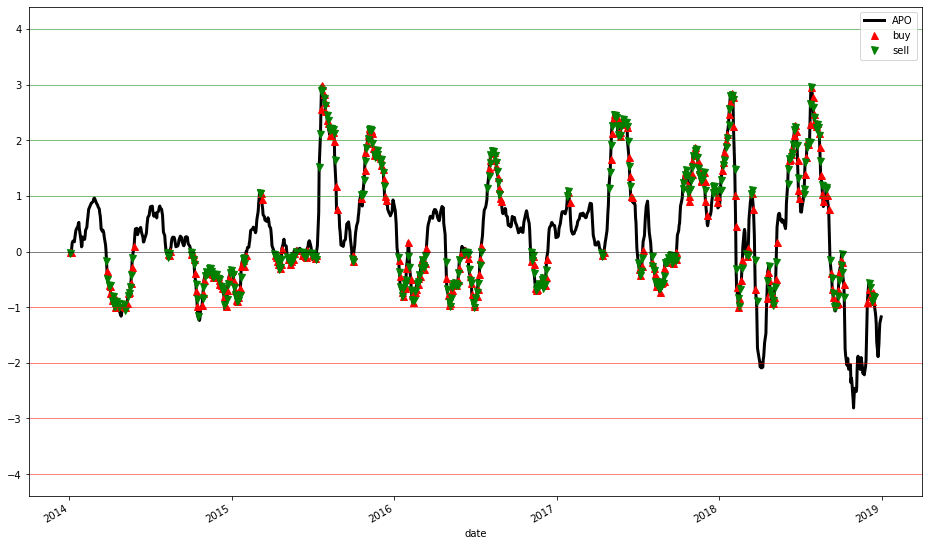

In [9]:
plt.figure(figsize=(16,10))
data['APO'].plot(color='k', lw=3., legend=True)
plt.plot(data.loc[ data.Trades == 1 ].index, data.APO[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.APO[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( APO_VALUE_FOR_BUY_ENTRY, APO_VALUE_FOR_BUY_ENTRY*5, APO_VALUE_FOR_BUY_ENTRY ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( APO_VALUE_FOR_SELL_ENTRY, APO_VALUE_FOR_SELL_ENTRY*5, APO_VALUE_FOR_SELL_ENTRY ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

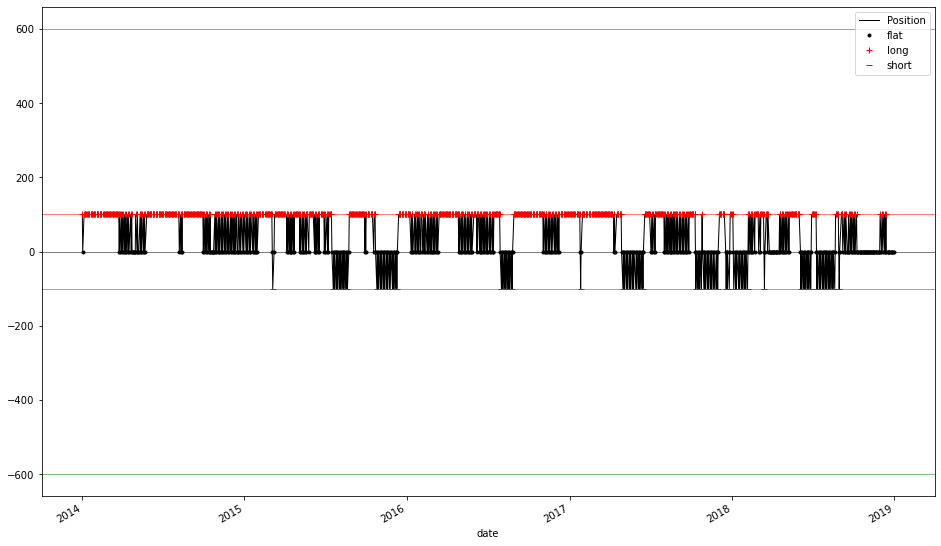

In [10]:
plt.figure(figsize=(16,10))
data['Position'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[ data.Position == 0 ].index, data.Position[ data.Position == 0 ], color='k', lw=0, marker='.', label='flat')
plt.plot(data.loc[ data.Position > 0 ].index, data.Position[ data.Position > 0 ], color='r', lw=0, marker='+', label='long')
plt.plot(data.loc[ data.Position < 0 ].index, data.Position[ data.Position < 0 ], color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( NUM_SHARES_PER_TRADE, NUM_SHARES_PER_TRADE*10, NUM_SHARES_PER_TRADE*5 ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( -NUM_SHARES_PER_TRADE, -NUM_SHARES_PER_TRADE*10, -NUM_SHARES_PER_TRADE*5 ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

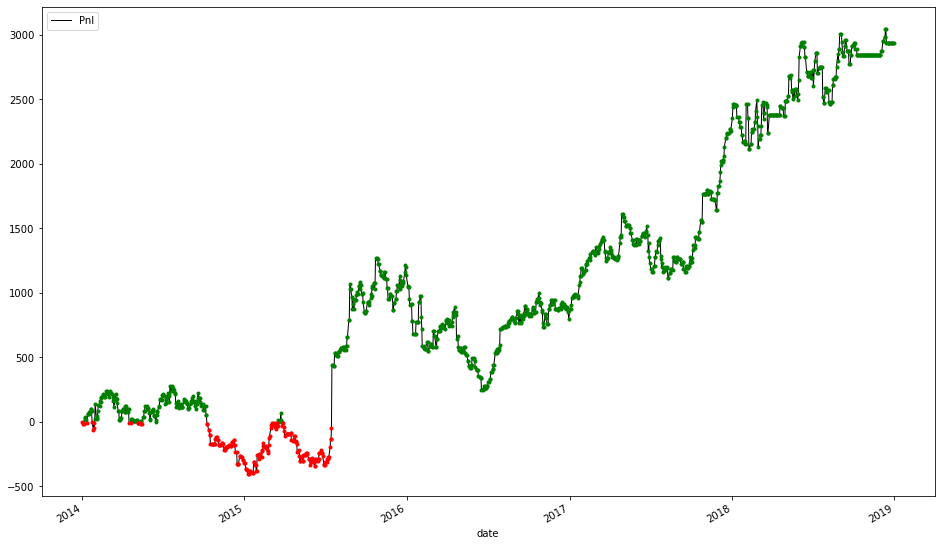

In [11]:
plt.figure(figsize=(16,10))
data['Pnl'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[ data.Pnl > 0 ].index, data.Pnl[ data.Pnl > 0 ], color='g', lw=0, marker='.')
plt.plot(data.loc[ data.Pnl < 0 ].index, data.Pnl[ data.Pnl < 0 ], color='r', lw=0, marker='.')
plt.legend()
plt.show()